# Lab 8/9 Report:
## Classify Gravitational Waves

### Name: Travis Hand, Arun Iyer

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Categorical
import h5py
import tqdm
import scipy
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from scipy.signal import butter, sosfiltfilt, welch
from torch.cuda.amp import autocast, GradScaler
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
from torch.utils.data import WeightedRandomSampler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os  # Standard Python library import
os.chdir('/content/drive/MyDrive/')  # Change current working directory to Google Drive path
os.getcwd()  # Confirm the current working directory

'/content/drive/MyDrive'

In [ ]:
# PyTorch Dataset base class
class GravitationalWaveDataset(Dataset):
    def __init__(self, file_path, label_map, train=True, transform=None, band=(20, 500), fs=4096):
        """
        Initializes the dataset by reading the HDF5 file and preparing data and labels.

        Args:
            file_path (str): Path to the HDF5 file.
            label_map (dict): Maps string labels to integer indices.
            train (bool): Whether the dataset is used for training (enables augmentation).
            transform (callable): Optional transform to apply to each sample.
            band (tuple): Bandpass filter range (in Hz).
            fs (int): Sampling frequency of the signal.
        """
        self.data = []
        self.labels = []
        self.train = train
        self.transform = transform
        self.label_map = label_map
        self.band = band
        self.fs = fs

        # Load data from HDF5 file
        with h5py.File(file_path, 'r') as f:
            for label, idx in label_map.items():
                dataset = f[label][:]  # e.g., shape (2048, 2, 4096)
                self.data.append(dataset)
                self.labels += [idx] * len(dataset)

        # Concatenate data arrays along the sample axis: final shape (N, 2, 4096)
        self.data = np.concatenate(self.data)
        self.labels = np.array(self.labels)

    def __len__(self):
        """
        Returns total number of samples in the dataset.
        """
        return len(self.data)

    def bandpass_filter(self, signal):
        """
        Applies a 4th-order bandpass Butterworth filter to the input signal.

        Args:
            signal (np.array): 1D time-series signal.

        Returns:
            Filtered signal.
        """
        sos = butter(N=4, Wn=[self.band[0], self.band[1]], btype='band', fs=self.fs, output='sos')
        return sosfiltfilt(sos, signal)

    def __getitem__(self, idx):
        """
        Retrieves and processes a single sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            x (torch.Tensor): Preprocessed signal tensor (2, 4096).
            y (torch.Tensor): Corresponding label tensor.
        """
        x = self.data[idx]
        y = self.labels[idx]

        # Normalize and filter each channel independently (L1, H1)
        for i in range(x.shape[0]):
            x[i] = (x[i] - x[i].mean()) / (x[i].std() + 1e-8)  # Normalize to zero mean, unit variance
            x[i] = self.bandpass_filter(x[i])  # Apply bandpass filter

        # Randomly shift the signal in time by up to ±128 samples (data augmentation)
        shift = np.random.randint(-128, 128)
        x = np.roll(x, shift, axis=-1)

        # If in training mode, apply additional augmentation
        if self.train:
            L = x.shape[-1]
            w = int(0.10 * L)  # 10% of the signal length as mask width
            s = torch.randint(0, L - w, (1,)).item()  # Random start index
            x[:, s : s + w] = 0  # Zero out both channels in the mask region
            x = x + 0.001 * torch.randn_like(x)  # Add slight Gaussian noise

        # Apply optional transform (if provided)
        if self.transform:
            x = self.transform(x)

        # Convert to PyTorch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return x, y


# Mapping class names to integer indices
label_map = {
    'background': 0,
    'binaryblackhole': 1,
    'ccsn': 2,
    'glitch': 3
}

# Instantiate dataset (with augmentation enabled by default)
dataset = GravitationalWaveDataset('./GW2_Andy.h5', label_map, train=True)

# Split into training, validation, and test sets (70/20/10 split)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size])

# Toggle data augmentation for each subset
train_dataset.dataset.train = True
val_dataset.dataset.train = False
test_dataset.dataset.train = False

# Number of parallel data-loading worker processes
worker_count = 6

# DataLoader for training (shuffled, augmented)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                          num_workers=worker_count, pin_memory=True)

# DataLoaders for validation and test (no shuffle, no augmentation)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                        num_workers=worker_count, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                         num_workers=worker_count, pin_memory=True)

## Define Model

In [ ]:
# 1D Inception block adapted for time-series signals
class InceptionBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, depthwise=False):
        super().__init__()

        # Inner function to define convolution layer(s)
        def conv(k):
            # Use depthwise separable convolution if enabled
            if depthwise:
                return nn.Sequential(
                    # Depthwise convolution: one filter per input channel
                    nn.Conv1d(in_ch, in_ch, k, stride=stride,
                              padding=k//2, groups=in_ch, bias=False),
                    # Pointwise convolution: mixes channels
                    nn.Conv1d(in_ch, out_ch, 1, bias=False))
            else:
                # Standard convolution
                return nn.Conv1d(in_ch, out_ch, k,
                                 stride=stride, padding=k//2, bias=False)

        # Four convolution branches with different receptive fields
        self.branch1 = conv(1)  # Smallest kernel: fine detail
        self.branch3 = conv(3)  # Medium kernel: moderate context
        self.branch5 = conv(5)  # Large kernel: broader features
        self.branch7 = conv(7)  # Largest kernel: long-range dependencies

        # Pooling branch: aggregates context, then reduces channels via 1x1 conv
        self.pool     = nn.MaxPool1d(3, stride=stride, padding=1)
        self.br_pool  = nn.Conv1d(in_ch, out_ch, 1, bias=False)

    def forward(self, x):
        # Concatenate the outputs from all five branches along the channel axis
        return torch.cat([
            self.branch1(x),
            self.branch3(x),
            self.branch5(x),
            self.branch7(x),
            self.br_pool(self.pool(x))
        ], dim=1)


# Main CNN model for gravitational wave classification
class GWClassifier(nn.Module):
    def __init__(self,
                 in_channels: int = 2,         # Two detectors: L1, H1
                 base_channels: int = 32,      # Base width for channels
                 num_classes: int = 4,         # Number of output classes
                 depthwise: bool = False):     # Whether to use depthwise separable convs
        super().__init__()

        self.branch_count = 5  # Each Inception block outputs 5 * out_channels

        # -------------------- Block 1 --------------------
        self.incept1 = InceptionBlock1D(
            in_channels, base_channels,
            stride=2, depthwise=depthwise)  # Downsamples by factor of 2
        self.out1_channels = self.branch_count * base_channels
        self.bn1 = nn.BatchNorm1d(self.out1_channels)

        # -------------------- Block 2 --------------------
        self.incept2 = InceptionBlock1D(
            self.out1_channels, base_channels * 2,
            stride=2, depthwise=depthwise)
        self.out2_channels = self.branch_count * base_channels * 2
        self.bn2 = nn.BatchNorm1d(self.out2_channels)

        # -------------------- Block 3 --------------------
        self.incept3 = InceptionBlock1D(
            self.out2_channels, base_channels * 2,
            stride=2, depthwise=depthwise)
        self.out3_channels = self.branch_count * base_channels * 2
        self.bn3 = nn.BatchNorm1d(self.out3_channels)

        # -------------------- Block 4 --------------------
        self.incept4 = InceptionBlock1D(
            self.out3_channels, base_channels * 2,
            stride=2, depthwise=depthwise)
        self.out4_channels = self.branch_count * base_channels * 2
        self.bn4 = nn.BatchNorm1d(self.out4_channels)

        # -------------------- Classification Head --------------------

        # Global pooling (per feature map) reduces time dimension to 1
        self.global_pool_avg = nn.AdaptiveAvgPool1d(1)
        self.global_pool_max = nn.AdaptiveMaxPool1d(1)

        # Fully connected classifier
        self.fc  = nn.Linear(self.out4_channels * 2, 32)  # Combined max + avg pooled channels
        self.fc2 = nn.Linear(32, num_classes)

        self.dropout = nn.Dropout(0.4)  # Prevent overfitting
        self.relu = nn.ReLU(inplace=True)

        self.init_weights()  # Optional custom initialization

    # -------------------- Weight Initialization --------------------
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # Good for ReLU
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    # -------------------- Forward Pass --------------------
    def forward(self, x):
        # Pass through each inception block with BN and ReLU
        x = self.relu(self.bn1(self.incept1(x)))
        x = self.relu(self.bn2(self.incept2(x)))
        x = self.dropout(x)  # Dropout between blocks
        x = self.relu(self.bn3(self.incept3(x)))
        x = self.relu(self.bn4(self.incept4(x)))

        # Global average and max pooling: (B, C, T) → (B, C, 1)
        avg_pool = self.global_pool_avg(x)
        max_pool = self.global_pool_max(x)

        # Concatenate pooled features and remove singleton time dim
        x = torch.cat([avg_pool, max_pool], dim=1).squeeze(-1)  # (B, 2C)

        x = self.dropout(x)
        x = self.fc(x)
        x = self.fc2(x)  # Final output logits (B, num_classes)

        return x


In [ ]:
# Use GPU if available, otherwise run on CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Define Hyperparameters

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=torch.ones(4), gamma=1.0, reduction="mean"):
        super().__init__()

        # alpha: weighting factor for each class (e.g., to counter class imbalance)
        self.alpha = alpha if alpha is not None else torch.ones(4)

        # gamma: focusing parameter (higher → focus more on hard examples)
        self.gamma = gamma

        # reduction: "mean" to return average loss, else returns element-wise loss
        self.reduction = reduction


def forward(self, logits, targets):
    # Step 1: Compute standard cross-entropy loss for each sample, without reducing to a mean
    # Shape: (batch_size,)
    ce = F.cross_entropy(logits, targets, reduction="none")

    # Step 2: Compute pt, the probability of the correct class for each sample
    # Since ce = -log(pt), we get pt = exp(-ce)
    pt = torch.exp(-ce)

    # Step 3: Gather alpha for each sample based on its true class label
    # alpha is a tensor of class weights (e.g., [1, 2, 1, 1] for class imbalance)
    # Shape of at: (batch_size,)
    at = self.alpha.to(logits.device).gather(0, targets)

    # Step 4: Compute focal loss for each sample
    # The formula is: FL = alpha_t * (1 - pt)^gamma * CE
    # - (1 - pt)^gamma reduces the weight of easy examples
    # - at scales the loss depending on class importance
    focal = at * (1 - pt) ** self.gamma * ce

    # Step 5: Return either the mean of losses or the raw loss per sample
    return focal.mean() if self.reduction == "mean" else focal


In [ ]:
# Fix random seed
torch.manual_seed(25)

# Define Epochs
num_epochs = 30

# Define RNN network
model = GWClassifier(base_channels=64, depthwise=True)

# Define scaler
scaler = GradScaler()

# Define loss function and optimizer
ce_weights = torch.tensor([1.45, 1.0, 1.25, 1.0],   # bg, bbh, ccsn, glitch
                          dtype=torch.float32,
                          device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weights, label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# One-Cycle LR schedule
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-3,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    pct_start=0.3
)

# Best Bias for CCSN
best_bias = -0.05

swa_start = int(0.8 * num_epochs) # start averaging after 80 %
swa_model  = AveragedModel(model).to(device) # running weight average
swa_sched  = SWALR(optimizer, swa_lr=3e-4) # flat, low LR once SWA begins

# add .cuda() for GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

<ipython-input-8-52ecd0eddf7c>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Identify Tracked Values

In [ ]:
# Tracking training loss per each input/target sequence fwd/bwd pass
training_loss = []
validation_accuracy = []

## Train Model

In [ ]:
def mixup(x, y, alpha=0.1):
    # Sample lambda from a Beta(alpha, alpha) distribution
    # This controls the strength of interpolation between samples
    lam = np.random.beta(alpha, alpha)

    # Generate a random permutation of the batch indices
    # Used to shuffle the batch and pair each sample with another
    idx = torch.randperm(x.size(0), device=x.device)

    # Perform the linear interpolation between original and shuffled samples
    # For input:  x_mix = lam * x + (1 - lam) * x[idx]
    # For labels: y_mix = lam * y + (1 - lam) * y[idx] (computed externally)
    return lam * x + (1 - lam) * x[idx], lam, idx


mixup_start = 10 # epoch to start MixUp (0-based counting)

In [ ]:
for epoch in tqdm.trange(num_epochs):  # Iterate through each training epoch
    model.train()  # Set model to training mode

    # Initialize running metrics
    running_loss = 0.0
    running_total = 0
    correct = 0

    # Loop through mini-batches
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # ----------------------- MixUp Augmentation -----------------------
        if epoch >= mixup_start:
            inputs, lam, idx = mixup(inputs, labels)  # Mix input and shuffled versions
            labels_a, labels_b = labels, labels[idx]  # Keep original and mixed labels
        else:
            lam = 1.0  # No mixing
            labels_a, labels_b = labels, labels  # Dummy values

        # ----------------------- Forward & Backward Pass -----------------------
        optimizer.zero_grad(set_to_none=True)  # Clear gradients efficiently

        with autocast():  # Automatic Mixed Precision for efficiency
            outputs = model(inputs)

            # Compute loss using MixUp interpolation if active
            if lam == 1.0:
                loss = criterion(outputs, labels_a)
            else:
                loss = lam * criterion(outputs, labels_a) + \
                       (1 - lam) * criterion(outputs, labels_b)

        # Scale loss for mixed precision and backpropagate
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # ----------------------- Learning Rate Scheduler -----------------------
        if epoch >= swa_start:
            swa_sched.step()  # Small constant LR for SWA phase
        else:
            scheduler.step()  # Standard learning rate scheduler

        # ----------------------- Accuracy Calculation -----------------------
        _, preds = torch.max(outputs, 1)  # Get predicted class indices

        if lam == 1.0:
            batch_correct = (preds == labels_a).sum().item()
        else:
            # Compute soft MixUp accuracy as expected correct predictions
            batch_correct = (
                lam * (preds == labels_a).float() +
                (1 - lam) * (preds == labels_b).float()
            ).sum()

        # Accumulate stats for epoch
        running_loss += loss.detach()  # Don't track gradients for stats
        correct += batch_correct
        running_total += preds.size(0)  # Total number of samples seen

    # ----------------------- End of Epoch Training Metrics -----------------------
    train_loss = running_loss.cpu().item() / len(train_loader.dataset)
    train_acc = correct / running_total
    training_loss.append(train_loss)

    # ----------------------- Validation Loop -----------------------
    model.eval()  # Switch to eval mode for validation (disables dropout, etc.)
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():  # No gradient tracking during validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)  # Accumulate total loss
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)  # Normalize loss
    val_acc = val_correct / len(val_loader.dataset)
    validation_accuracy.append(val_acc)

    # Print metrics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    # ----------------------- SWA Weight Averaging -----------------------
    if epoch >= swa_start:
        swa_model.update_parameters(model)  # Update SWA weights with current model


print("SWA: updating BatchNorm statistics…")
update_bn(train_loader, swa_model, device=device)  # Recompute batchnorm stats for SWA model
model = swa_model  # Replace model with its SWA-averaged version for final use

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-11-18aed8e9ff47>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  3%|▎         | 1/30 [00:11<05:22, 11.12s/it]

Epoch 1/30 - Train Loss: 0.0187 - Train Acc: 0.5056 - Val Loss: 0.9527 - Val Acc: 0.6349


  7%|▋         | 2/30 [00:21<04:58, 10.68s/it]

Epoch 2/30 - Train Loss: 0.0148 - Train Acc: 0.6322 - Val Loss: 1.1170 - Val Acc: 0.6013


 10%|█         | 3/30 [00:31<04:45, 10.57s/it]

Epoch 3/30 - Train Loss: 0.0142 - Train Acc: 0.6711 - Val Loss: 0.7974 - Val Acc: 0.7741


 13%|█▎        | 4/30 [00:42<04:31, 10.45s/it]

Epoch 4/30 - Train Loss: 0.0137 - Train Acc: 0.6913 - Val Loss: 0.8999 - Val Acc: 0.7082


 17%|█▋        | 5/30 [00:52<04:19, 10.36s/it]

Epoch 5/30 - Train Loss: 0.0122 - Train Acc: 0.7398 - Val Loss: 0.7103 - Val Acc: 0.7723


 20%|██        | 6/30 [01:02<04:06, 10.29s/it]

Epoch 6/30 - Train Loss: 0.0118 - Train Acc: 0.7656 - Val Loss: 0.9673 - Val Acc: 0.6123


 23%|██▎       | 7/30 [01:12<03:55, 10.24s/it]

Epoch 7/30 - Train Loss: 0.0112 - Train Acc: 0.7776 - Val Loss: 0.8259 - Val Acc: 0.7131


 27%|██▋       | 8/30 [01:22<03:45, 10.23s/it]

Epoch 8/30 - Train Loss: 0.0113 - Train Acc: 0.7742 - Val Loss: 0.9244 - Val Acc: 0.6593


 30%|███       | 9/30 [01:33<03:35, 10.26s/it]

Epoch 9/30 - Train Loss: 0.0105 - Train Acc: 0.8042 - Val Loss: 0.7187 - Val Acc: 0.7949


 33%|███▎      | 10/30 [01:43<03:25, 10.28s/it]

Epoch 10/30 - Train Loss: 0.0100 - Train Acc: 0.8136 - Val Loss: 0.7078 - Val Acc: 0.7772


 37%|███▋      | 11/30 [01:53<03:15, 10.30s/it]

Epoch 11/30 - Train Loss: 0.0122 - Train Acc: 0.7658 - Val Loss: 0.8814 - Val Acc: 0.6111


 40%|████      | 12/30 [02:04<03:05, 10.31s/it]

Epoch 12/30 - Train Loss: 0.0115 - Train Acc: 0.7803 - Val Loss: 0.8416 - Val Acc: 0.7393


 43%|████▎     | 13/30 [02:14<02:55, 10.30s/it]

Epoch 13/30 - Train Loss: 0.0109 - Train Acc: 0.7994 - Val Loss: 0.6613 - Val Acc: 0.8376


 47%|████▋     | 14/30 [02:24<02:45, 10.31s/it]

Epoch 14/30 - Train Loss: 0.0110 - Train Acc: 0.7967 - Val Loss: 0.6124 - Val Acc: 0.8413


 50%|█████     | 15/30 [02:35<02:34, 10.31s/it]

Epoch 15/30 - Train Loss: 0.0108 - Train Acc: 0.8057 - Val Loss: 0.6037 - Val Acc: 0.8547


 53%|█████▎    | 16/30 [02:45<02:24, 10.32s/it]

Epoch 16/30 - Train Loss: 0.0105 - Train Acc: 0.8094 - Val Loss: 0.7516 - Val Acc: 0.7082


 57%|█████▋    | 17/30 [02:55<02:14, 10.32s/it]

Epoch 17/30 - Train Loss: 0.0107 - Train Acc: 0.8079 - Val Loss: 0.7486 - Val Acc: 0.7808


 60%|██████    | 18/30 [03:06<02:03, 10.30s/it]

Epoch 18/30 - Train Loss: 0.0105 - Train Acc: 0.8146 - Val Loss: 0.5914 - Val Acc: 0.8504


 63%|██████▎   | 19/30 [03:16<01:53, 10.31s/it]

Epoch 19/30 - Train Loss: 0.0107 - Train Acc: 0.8065 - Val Loss: 0.6049 - Val Acc: 0.8449


 67%|██████▋   | 20/30 [03:26<01:43, 10.32s/it]

Epoch 20/30 - Train Loss: 0.0105 - Train Acc: 0.8106 - Val Loss: 0.6100 - Val Acc: 0.8388


 70%|███████   | 21/30 [03:37<01:32, 10.31s/it]

Epoch 21/30 - Train Loss: 0.0101 - Train Acc: 0.8270 - Val Loss: 0.5855 - Val Acc: 0.8578


 73%|███████▎  | 22/30 [03:47<01:22, 10.36s/it]

Epoch 22/30 - Train Loss: 0.0101 - Train Acc: 0.8235 - Val Loss: 0.6000 - Val Acc: 0.8596


 77%|███████▋  | 23/30 [03:57<01:12, 10.35s/it]

Epoch 23/30 - Train Loss: 0.0102 - Train Acc: 0.8181 - Val Loss: 0.5803 - Val Acc: 0.8639


 80%|████████  | 24/30 [04:08<01:01, 10.32s/it]

Epoch 24/30 - Train Loss: 0.0097 - Train Acc: 0.8293 - Val Loss: 0.5622 - Val Acc: 0.8571


 83%|████████▎ | 25/30 [04:18<00:51, 10.31s/it]

Epoch 25/30 - Train Loss: 0.0095 - Train Acc: 0.8403 - Val Loss: 0.5725 - Val Acc: 0.8516


 87%|████████▋ | 26/30 [04:28<00:41, 10.31s/it]

Epoch 26/30 - Train Loss: 0.0094 - Train Acc: 0.8424 - Val Loss: 0.5873 - Val Acc: 0.8400


 90%|█████████ | 27/30 [04:38<00:30, 10.29s/it]

Epoch 27/30 - Train Loss: 0.0097 - Train Acc: 0.8309 - Val Loss: 0.5514 - Val Acc: 0.8681


 93%|█████████▎| 28/30 [04:49<00:20, 10.33s/it]

Epoch 28/30 - Train Loss: 0.0099 - Train Acc: 0.8228 - Val Loss: 0.5680 - Val Acc: 0.8523


 97%|█████████▋| 29/30 [04:59<00:10, 10.30s/it]

Epoch 29/30 - Train Loss: 0.0101 - Train Acc: 0.8225 - Val Loss: 0.5700 - Val Acc: 0.8529


100%|██████████| 30/30 [05:09<00:00, 10.33s/it]

Epoch 30/30 - Train Loss: 0.0101 - Train Acc: 0.8251 - Val Loss: 0.5674 - Val Acc: 0.8565
SWA: updating BatchNorm statistics…


In [ ]:
finetune_epochs = 5 # Number of epochs to fine-tune after main training

# Define cross-entropy loss with class weights to handle class imbalance
criterion_ft = nn.CrossEntropyLoss(weight=ce_weights)

# Low learning rate optimizer for fine-tuning
# AdamW is retained to preserve weight decay behavior
optimizer_ft = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Cosine annealing learning rate scheduler over 5 epochs
# Smoothly decreases LR from 5e-5 to 1e-6
sched_ft = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_ft, T_max=finetune_epochs, eta_min=1e-6
)

# Gradient scaler for mixed precision training (saves memory and speeds up training)
scaler_ft = GradScaler()

# Turn on training mode (enables dropout, batch norm updates, etc.)
# MixUp is intentionally disabled here for training stability
model.train()

for ep in range(finetune_epochs):
    # Reset tracking metrics for the epoch
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        # Move inputs and labels to the selected device (e.g., GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset gradients
        optimizer_ft.zero_grad(set_to_none=True)

        # Forward pass with mixed precision
        with autocast():
            outputs = model(inputs)               # Forward pass
            loss = criterion_ft(outputs, labels)  # Standard cross-entropy loss

        # Backward pass with gradient scaling
        scaler_ft.scale(loss).backward()
        scaler_ft.step(optimizer_ft)
        scaler_ft.update()

        # Compute predictions
        _, preds = torch.max(outputs, 1)

        # Accumulate metrics
        running_loss += loss.detach()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Step the learning rate scheduler after each epoch
    sched_ft.step()

    # Log fine-tuning metrics for this epoch
    print(f"[FT] Epoch {ep+1}/{finetune_epochs} "
          f"loss={running_loss.item()/total:.4f}  "
          f"acc={correct/total:.4f}")

print("Re-computing SWA weights & BatchNorm stats…")

# Initialize SWA model from the final fine-tuned model weights
swa_model = AveragedModel(model)
swa_model.to(device)

# Recompute BatchNorm running statistics using the training set
update_bn(train_loader, swa_model, device=device)

# Swap in the SWA-averaged model as the final model for evaluation/inference
model = swa_model

<ipython-input-12-19deac12e826>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_ft = GradScaler()
<ipython-input-12-19deac12e826>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[FT] Epoch 1/5 loss=0.0062  acc=0.8701
[FT] Epoch 2/5 loss=0.0059  acc=0.8708
[FT] Epoch 3/5 loss=0.0057  acc=0.8764
[FT] Epoch 4/5 loss=0.0057  acc=0.8744
[FT] Epoch 5/5 loss=0.0058  acc=0.8730
Re-computing SWA weights & BatchNorm stats…


## Visualize & Evaluate Model

In [ ]:
def tta_logits(xb):
    # xb : (B, 2, 4096)
    shifts  = [0, 64, 128, -64]
    logits  = 0
    for s in shifts:
        rolled = torch.roll(xb, s, dims=-1)
        logits += model(rolled)                 # normal
        logits += model(torch.flip(rolled, [-1]))  # time-reversed
    return logits / (2 * len(shifts))

In [ ]:
# Set model to evaluation mode (disables dropout, uses running batchnorm stats)
model.eval()

# Initialize accumulators for test loss and accuracy
test_loss = 0.0
test_correct = 0

# Disable gradient computation to speed up inference and reduce memory usage
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move input tensors to the appropriate device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the model (with optional Test-Time Augmentation)
        outputs = tta_logits(inputs)  # Use TTA wrapper if defined (otherwise use model(inputs))

        # Add a bias vector to logits for class calibration
        # Only the third class (index 2) is adjusted by best_bias
        bias = torch.tensor([0.0, 0.0, best_bias, 0.0], device=outputs.device)
        outputs += bias

        # Compute loss for the batch
        loss = criterion(outputs, labels)

        # Accumulate total loss (scaled by batch size)
        test_loss += loss.item() * inputs.size(0)

        # Get predicted class indices from logits
        _, preds = torch.max(outputs, 1)

        # Count number of correct predictions
        test_correct += (preds == labels).sum().item()

# Normalize total loss over entire validation set
test_loss /= len(val_loader.dataset)

# Compute overall accuracy over the test set
test_acc = test_correct / len(test_loader.dataset)

# Print final evaluation metrics
print(f"test_loss: {test_loss:.4f} -- test accuracy: {test_acc:.4f}")

test_loss: 0.2921 -- test accuracy: 0.8476


In [ ]:
# Import seaborn for prettier plot
import seaborn as sns  # Standard Python library import

sns.set(style = 'whitegrid', font_scale = 2.5)

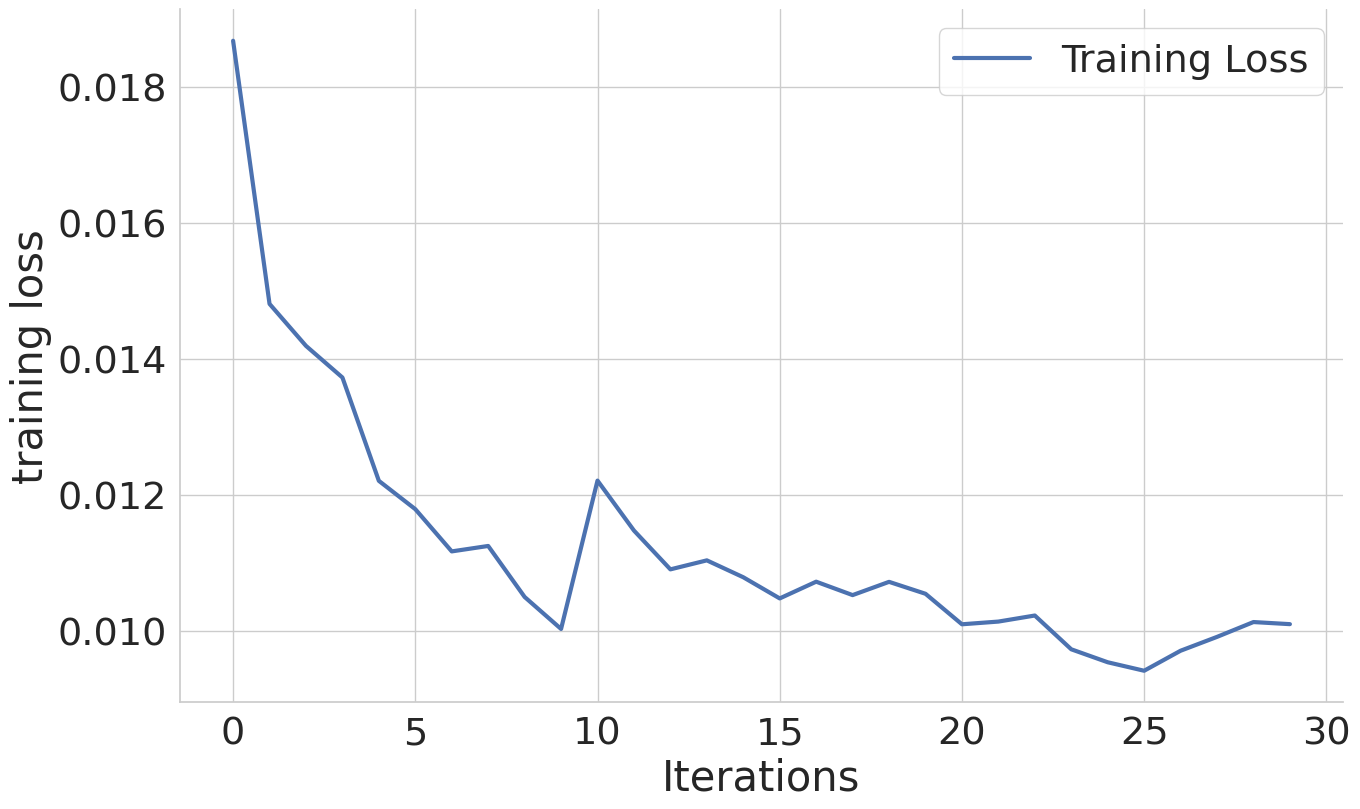

In [ ]:
# Plot the training loss and rolling mean training loss with respect to iterations
# Feel free to change the window size
plt.figure(figsize = (15, 9))

plt.plot(training_loss, linewidth = 3, label = 'Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

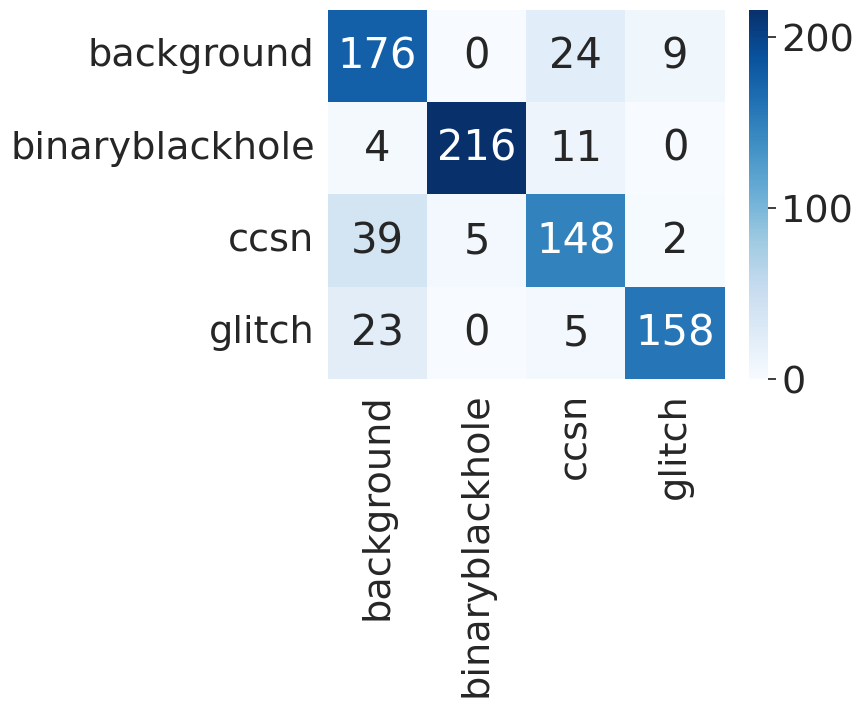

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt  # Import Matplotlib for plotting

def biased_preds(xb, bias):
    logits = tta_logits(xb)                     # 8-view TTA
    logits[:, 2] += bias                        # index 2 = CCSN
    return logits.argmax(1)

model.eval()
all_p, all_t = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        all_p.append(biased_preds(xb, best_bias).cpu()) #  Run biased prediction, move to CPU
        all_t.append(yb.cpu()) # Store true labels (also on CPU for sklearn)

cm = confusion_matrix(torch.cat(all_t), torch.cat(all_p))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.show()